## Import Data ##

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [3]:
image_path = []
labels = []

for i in os.listdir("/Users/jay/Jupyter Projects/Face/dataset"):
    for label in os.listdir(f"/Users/jay/Jupyter Projects/Face/dataset/{i}"):
        for image in os.listdir(f"/Users/jay/Jupyter Projects/Face/dataset/{i}"):
            image_path.append(f"/Users/jay/Jupyter Projects/Face/dataset/{i}/{image}")
            labels.append(i)

df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

,image_path,labels
0,/Users/jay/Jupyter Projects/Face/dataset/Happy...,Happy
1,/Users/jay/Jupyter Projects/Face/dataset/Happy...,Happy
2,/Users/jay/Jupyter Projects/Face/dataset/Happy...,Happy
3,/Users/jay/Jupyter Projects/Face/dataset/Happy...,Happy
4,/Users/jay/Jupyter Projects/Face/dataset/Happy...,Happy
...,...,...
15448,/Users/jay/Jupyter Projects/Face/dataset/Angry...,Angry
15449,/Users/jay/Jupyter Projects/Face/dataset/Angry...,Angry
15450,/Users/jay/Jupyter Projects/Face/dataset/Angry...,Angry
15451,/Users/jay/Jupyter Projects/Face/dataset/Angry...,Angry


## Statistical Modeling ##

Shape:  (15453, 2)

Counts:
 labels
Neutral     4027
Sad         3934
Happy       3740
Angry       1313
Surprise    1234
Ahegao      1205
Name: count, dtype: int64



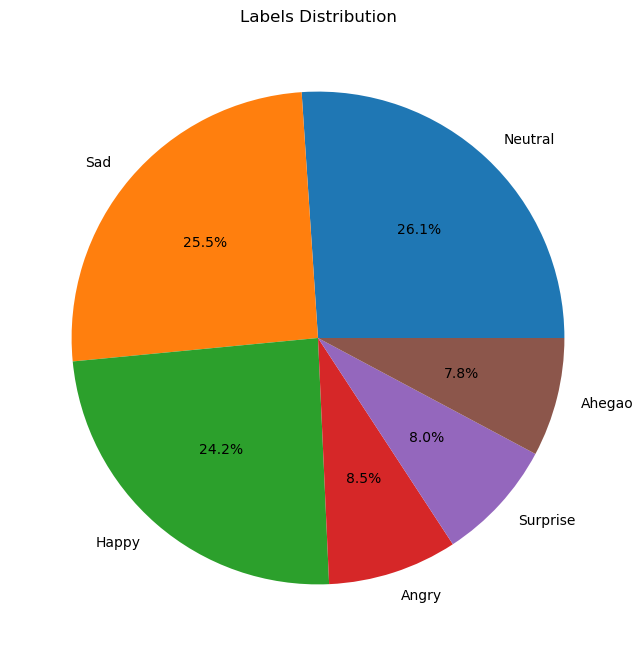

In [5]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["labels"].value_counts(), labels = df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

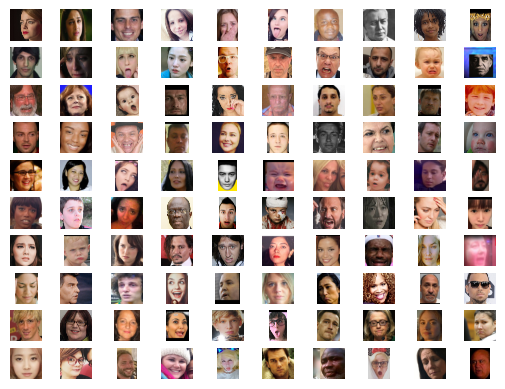

In [7]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()

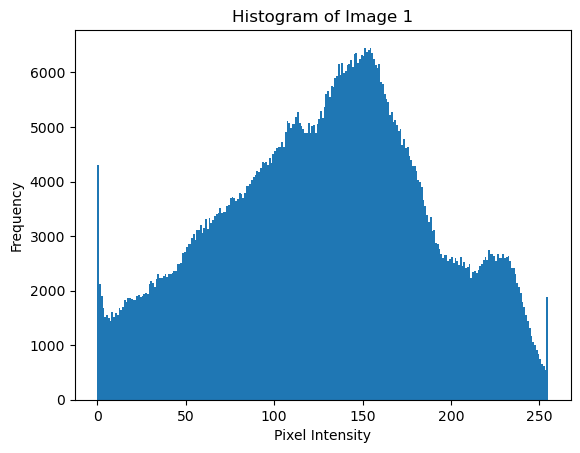

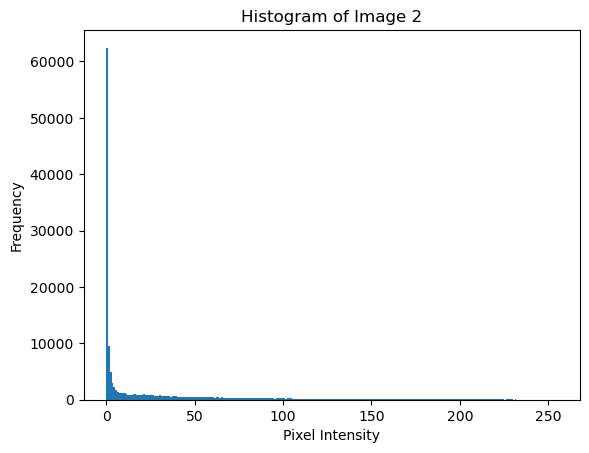

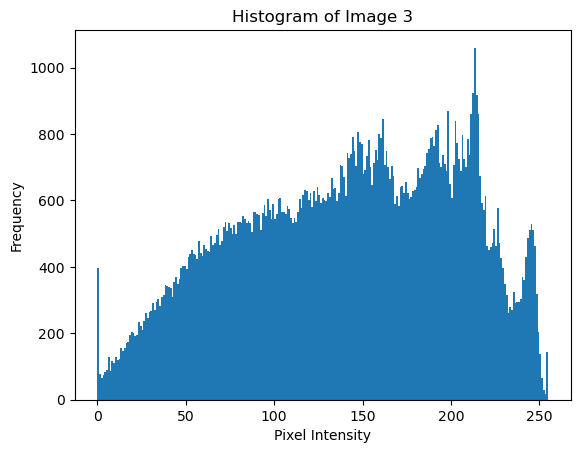

In [9]:
for i in range(3):
    plt.figure()
    
    img_data = np.array(Image.open(df.iloc[i, 0])).ravel()
    
    plt.hist(img_data, bins=range(256))
    
    plt.title(f"Histogram of Image {i+1}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    plt.show()

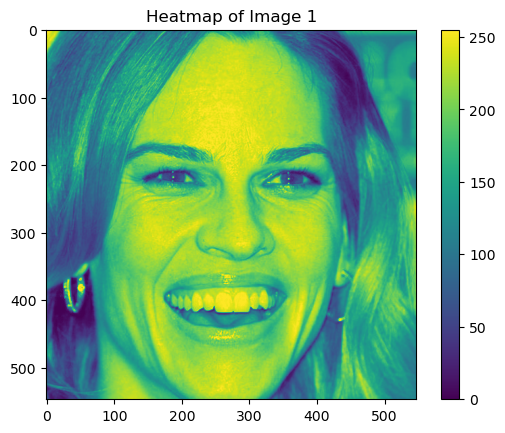

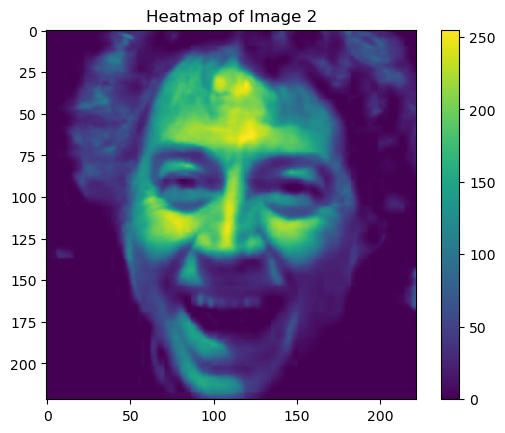

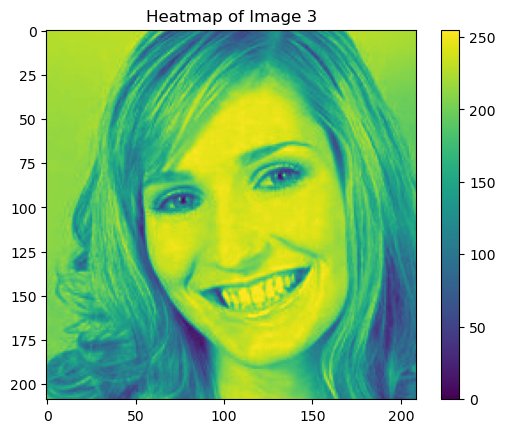

In [11]:
for i in range(3):
    plt.figure()

    img_data = np.array(Image.open(df.iloc[i, 0]))

    cax = plt.imshow(img_data, cmap="viridis", interpolation="nearest")

    plt.title(f"Heatmap of Image {i+1}")

    plt.colorbar(cax)

    plt.imshow(img_data[:, :, 0])

## Training Model ##

In [13]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(10817, 2)
(2318, 2)
(2318, 2)


In [15]:
le = LabelEncoder()
le.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [17]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [19]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

In [21]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [23]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [25]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16) same as number in self.linear
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [27]:
model = Net().to(device)

In [29]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─ReLU: 1-5                              --
├─Flatten: 1-6                           --
├─Linear: 1-7                            4,194,432
├─Linear: 1-8                            774
Total params: 4,288,454
Trainable params: 4,288,454
Non-trainable params: 0

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [33]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1/10 
    Training Loss: 0.9528 
    Training Accuracy: 41.3516 
    Validation Loss: 0.1722 
    Validation Accuracy: 52.3296
Epoch no. 2/10 
    Training Loss: 0.7579 
    Training Accuracy: 55.6624 
    Validation Loss: 0.1543 
    Validation Accuracy: 56.9025
Epoch no. 3/10 
    Training Loss: 0.6622 
    Training Accuracy: 61.3201 
    Validation Loss: 0.1455 
    Validation Accuracy: 59.5772
Epoch no. 4/10 
    Training Loss: 0.5871 
    Training Accuracy: 65.8593 
    Validation Loss: 0.1412 
    Validation Accuracy: 61.2166
Epoch no. 5/10 
    Training Loss: 0.5241 
    Training Accuracy: 69.6589 
    Validation Loss: 0.1355 
    Validation Accuracy: 63.201
Epoch no. 6/10 
    Training Loss: 0.4598 
    Training Accuracy: 73.5694 
    Validation Loss: 0.1275 
    Validation Accuracy: 64.3658
Epoch no. 7/10 
    Training Loss: 0.4055 
    Training Accuracy: 76.805 
    Validation Loss: 0.1284 
    Validation Accuracy: 65.4875
Epoch no. 8/10 
    Training Loss: 0.3562 


In [35]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 65.4012 
Loss: 0.1405


## Post-Training Analysis ##

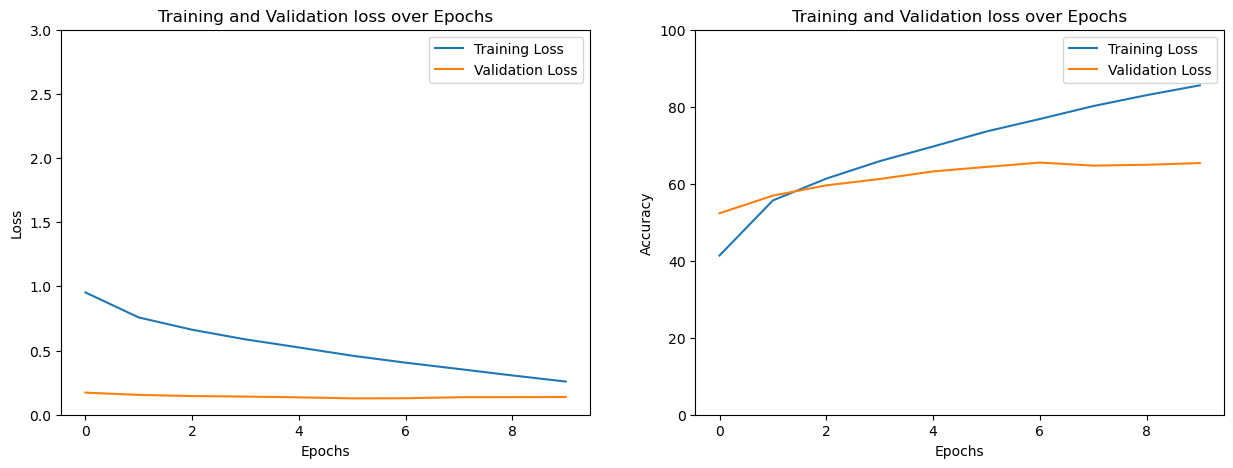

In [39]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,3])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()

In [41]:
torch.save(model.state_dict(), "face.pth")

In [43]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("face.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=6, bias=True)
)

In [45]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['Sad']


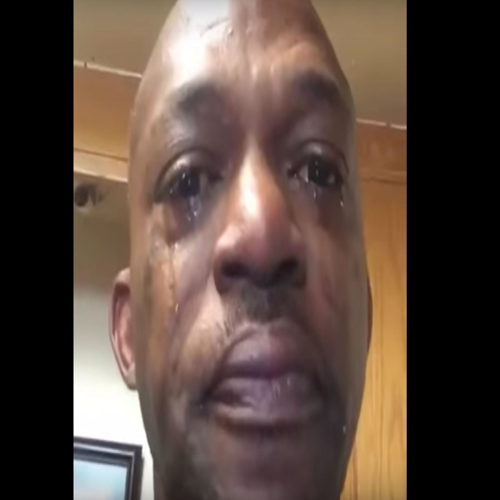

In [47]:
path1 = "/Users/jay/Jupyter Projects/Face/cry.jpg"
print(predict_image(path1))
Image.open(path1).convert("RGB").resize([500, 500])

['Neutral']


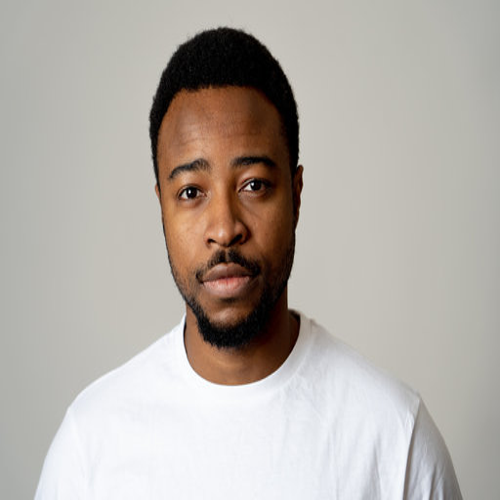

In [57]:
path2 = "/Users/jay/Jupyter Projects/Face/neutral.jpg"
print(predict_image(path2))
Image.open(path2).convert("RGB").resize([500, 500])

['Happy']


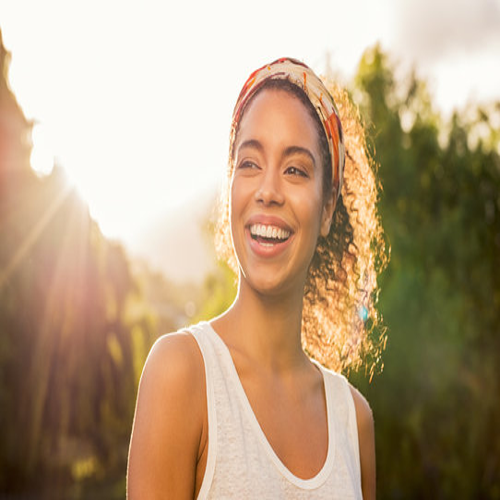

In [63]:
path3 = "/Users/jay/Jupyter Projects/Face/happy.jpeg"
print(predict_image(path3))
Image.open(path3).convert("RGB").resize([500, 500])